In [1]:
import os
import io 
import json
import math
import numpy as np
from PIL import Image 
from tqdm import tqdm
import matplotlib.pyplot as plt

import geopandas as gpd
import contextily as cx
from shapely.geometry import Point

import torch
from torchvision.models import resnet18
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import cosine_similarity

from llama_index.core import SimpleDirectoryReader, StorageContext, Settings
from llama_index.core import load_index_from_storage
from llama_index.core.schema import ImageNode
from llama_index.core.schema import ImageDocument
from llama_index.llms.ollama import Ollama
from llama_index.core import PromptTemplate
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.multi_modal_llms.ollama import OllamaMultiModal
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

##设置embeding 模型和llva模型
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
mm_model = OllamaMultiModal(model="llava")

c:\Users\20143\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
##将图片转换为patch
def img_to_patch(input_path, output_path, rows, cols):
    # 确保输出文件夹存在
    os.makedirs(output_path, exist_ok=True)

    # 遍历文件夹中的每个图像文件
    for filename in tqdm(os.listdir(input_path)):
        # 构建图像文件的完整路径
        image_file = os.path.join(input_path, filename)

        # 打开图像文件
        image = Image.open(image_file)

        # 获取图像的宽度和高度
        width, height = image.size

        # 计算每个块的宽度和高度
        patch_width = math.floor(width / cols)
        patch_height = math.floor(height / rows)

        # 遍历每个块的行和列
        for row in range(rows):
            for col in range(cols):
                # 计算当前块的边界框
                left = col * patch_width
                top = row * patch_height
                right = (col + 1) * patch_width
                bottom = (row + 1) * patch_height

                # 提取当前块的图像
                patch = image.crop((left, top, right, bottom))

                # 构造输出文件名
                filename_without_ext = os.path.splitext(filename)[0]
                patch_filename = f"{filename_without_ext}_patch_{row}_{col}.jpg"

                # 保存当前块的图像
                patch_path = os.path.join(output_path, patch_filename)
                patch.save(patch_path)

        # print(f"Saved patch: {patch_path}")
    return input_path, output_path

def leaf_retriever(leaf_index, query_img, topk):
    """" Note: query must a imge_path"""
    # leaf_index = index
    leaf = leaf_index.as_retriever(similarity_top_k=topk, image_similarity_top_k=topk)
    response = leaf.image_to_image_retrieve(query_img)  ##query是image_path
    print('Leaf_retrieve Complete!')
    return response  ##topk=10

def AutoMerge(base_retriever):
    retrieved_image_path = []
    retrieved_image_score = []
    for res_node in base_retriever:
        if isinstance(res_node.node, ImageNode):
            retrieved_image_path.append(res_node.node.image_path)
            retrieved_image_score.append(res_node.score)
        else:
            print('Wrong, please input ImageNode')

    retrieved_image_data = {}

    for path, score in zip(retrieved_image_path, retrieved_image_score):
        doc_name = path.split('\\')[-1].split('_patch')[0]  # 提取文档名称
        if doc_name in retrieved_image_data:
            retrieved_image_data[doc_name].append(score)
        else:
            retrieved_image_data[doc_name] = [score]
    
    merge_image = [[doc_name+'.jpg', sum(scores) / len(scores)] for doc_name, scores in retrieved_image_data.items()]
    print('AutoMerge Complete!')
    return merge_image

def rerank_embedding(image_path):
    # 加载预训练的 ResNet18 模型
    model = resnet18(pretrained=True)
    model.fc = torch.nn.Identity()  # 移除分类层，保留特征提取部分
    model.eval()

    # 图像预处理
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # 加载并预处理图像
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    image = image.unsqueeze(0)

    # 使用模型获取图像的嵌入向量
    with torch.no_grad():
        embedding = model(image)

    return embedding

def Rerank(orig_img, parent_img, merge_image, topk):
    orig_img_embedding = rerank_embedding(orig_img)

    similarity_scores = []
    img_files = os.listdir(parent_img)  # 获取父文件夹内的所有文件和文件夹

    for img_path, score in tqdm(merge_image):
        if img_path in img_files:  # 检查文件名是否存在于父文件夹中
            parent_img_path = os.path.join(parent_img, img_path)  # 构建完整的文件路径

            # 计算图像相似度
            img_similarity = torch.cosine_similarity(orig_img_embedding, rerank_embedding(parent_img_path))
            similarity = img_similarity.item()
            weighted_score = np.mean([similarity, score])
            # print(weighted_score)
            similarity_scores.append((parent_img_path, similarity, weighted_score))

    similarity_scores.sort(key=lambda x: x[2], reverse=True)
    print("Rerank Complete!")
    return similarity_scores[0:topk]   ##topk=3
    # return similarity_scores  ##topk=10

def parent_retriever(parent_index, rerank_list):
    """" Note: query must a imge_path"""
    # leaf_index = index
    parent_response = []
    average_score = []
    for path, score, score2 in rerank_list:
        # parent_retriever(parent_index, path)
        parent = parent_index.as_retriever(similarity_top_k=1, image_similarity_top_k=1)
        response = parent.image_to_image_retrieve(path)  ##query是image_path
        parent_response.append(response)
        average_score.append(score2)
    print('Parent_retrieve Complete!')
    return parent_response, average_score  ##topk=10

def plot_images(image_paths):
    # Initialize a counter to track the number of images shown
    images_shown = 0
    # Set the figure size for the entire plot
    plt.figure(figsize=(16, 9))
    # Iterate through each image path in the provided list
    for img_path in image_paths:
        # Check if the file exists
        if os.path.isfile(img_path):
            # Open the image using the Image module
            image = Image.open(img_path)
            # Create a subplot for the current image in a 2x3 grid
            plt.subplot(3, 2, images_shown + 1)
            # Display the image in the subplot
            plt.imshow(image)
            # Remove x and y ticks for clarity
            plt.xticks([])
            plt.yticks([])
            # Increment the counter for images shown
            images_shown += 1
            # Break the loop if 9 images have been shown
            if images_shown >= 9:
                break

def parent_retrieved_vis(parent_response, average_score):
    print(average_score)
    retrieved_image = []
    # retrieved_image_score = []
    retrieved_text = []
    retrieved_metadata = []
    for res_node in parent_response:
        for i in res_node:
            # print(i)
            retrieved_image.append(i.node.image_path)
            # retrieved_image_score.append(average_score)
            retrieved_text.append(i.node.text)
            retrieved_metadata.append(i.node.metadata)
    plot_images(retrieved_image)        
    
    return retrieved_image, retrieved_text, retrieved_metadata

def multi_img_retrieve(image_paths):
    images = []
    max_height = 300

    # 读取图像并调整为相同的高度
    for path in image_paths:
        image = Image.open(path)

        # 调整图像高度为最大高度
        height_ratio = max_height / image.size[1]
        new_width = int(image.size[0] * height_ratio)
        resized_image = image.resize((new_width, max_height))

        images.append(resized_image)

        # 更新最大高度
        if resized_image.size[1] > max_height:
            max_height = resized_image.size[1]

    # 获取图像的总宽度
    total_width = sum(img.size[0] for img in images)

    # 创建一个新的空白图像，用于拼接
    result = Image.new('RGB', (total_width, max_height))

    # 将图像拼接到结果图像中
    x_offset = 0
    for img in images:
        result.paste(img, (x_offset, 0))
        x_offset += img.size[0]

    # 保存拼接后的图像到文件夹中
    output_dir = 'E:/RAG_LLM/wuhan/concatenated_images'
    output_filename = 'concatenated_image.jpg'
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, output_filename)
    result.save(output_path)

    return output_path

def plot_location(metadata_str):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # 输入坐标点
    coordinates = [[metadata_str[0]['lng'], metadata_str[0]['lat']]]
    
    # 创建坐标点的 GeoDataFrame
    geometry = [Point(coord) for coord in coordinates]
    gdf = gpd.GeoDataFrame(geometry=geometry, columns=['geometry'], crs='EPSG:4326')
    df_loc = gdf.to_crs('EPSG:3857')
    
    boundry = gpd.read_file("E:/RAG_LLM/wuhan_roadnetworks/单线WGS.shp")
    boundry.crs = 'EPSG:4326'
    line = boundry.to_crs('EPSG:3857')
    
    line.plot(ax=ax, alpha=0.5, color='gray')
    df_loc.plot(ax=ax, alpha=0.5, color="r", markersize=20)
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    # ax.set_axis_off()
    
    plt.show()

def get_answer_to_question(question, context_str, metadata_str):
    mm_model = Ollama(model="llava")

    qa_tmpl_str = (
        "Given the provided information, including retrieved contents and metadata, \
         accurately and precisely answer the query without any additional prior knowledge.\n"
         "请使用中文回答。\n"
        # "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
        "---------------------\n"
        "Context: {context_str}\n"     ## 将上下文信息放进去
        "Metadata: {metadata_str} \n"  ## 将原始的meta信息放进去
        "---------------------\n"
        "Query: {query_str}\n"
        "Answer: "
    )

    query_str = question
    prompt = qa_tmpl_str.format(
            context_str=context_str,
            metadata_str=metadata_str,
            query_str=query_str
            )

    response = mm_model.complete(prompt)

    # answers = ""
    # for r in response:
    #     answers += r.delta

    return response.text

In [3]:
# import json
# with open('wuhan_parent_node.json') as f:
# 	doc = json.load(f)
      
# document = []
# for obj in doc:
#     caption = obj.get("text")
#     captions = str(caption)
#     # obj['City'] = str(obj.get("Image Name")).split('_')[3].split('.')[0]
#     image_path = obj.get("img_path")
#     image_paths = str(image_path)

#     obj.pop("text", None)
#     obj.pop("img_path", None)
    
#     document.append([image_paths, captions, obj])
# document[0]

# parent_nodes =[ImageNode(image_path=p, text=t,metadata=k) for p,t,k in document]
# print(parent_nodes[0])

# parent_indexing = MultiModalVectorStoreIndex(parent_nodes, show_progress=True)
# parent_indexing.storage_context.persist(persist_dir="E:/RAG_LLM/wuhan/parent_storage")


# def leaf_indexing(leaf_path):
#     documents = SimpleDirectoryReader(leaf_path).load_data()
#     node_parser = SentenceSplitter.from_defaults()
#     leaf_nodes = node_parser.get_nodes_from_documents(documents)
#     ##需要补充一个Qdrant库(判断是否需要重新indexing)
#     index = MultiModalVectorStoreIndex(leaf_nodes, show_progress=True)
#     return index

# leaf_indexing = leaf_indexing('E:/RAG_LLM/wuhan/wuhan_test_img_patch')
# # Save it
# leaf_indexing.storage_context.persist(persist_dir="E:/RAG_LLM/wuhan/leaf_storage")

In [4]:
parent_indexing = load_index_from_storage(StorageContext.from_defaults(persist_dir="E:/RAG_LLM/wuhan/parent_storage"))

leaf_indexing = load_index_from_storage(StorageContext.from_defaults(persist_dir="E:/RAG_LLM/wuhan/leaf_storage"))

In [5]:
import warnings
warnings.filterwarnings('ignore')

### Multi_Img_Retrieve

Leaf_retrieve Complete!
Leaf_retrieve Complete!
AutoMerge Complete!


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Rerank Complete!
Parent_retrieve Complete!
[0.8426631100255944]
 根据您提供的信息，您目前在湖北省武汉市洪山区新竹路6号。周围有许多商店和服务场所，包括家居建材市场、购物相关场所、烟酒专卖店、中餐厅等。您可以在这些地方购物、品尝美食或者享受其他服务。 
CPU times: total: 44.9 s
Wall time: 10.6 s


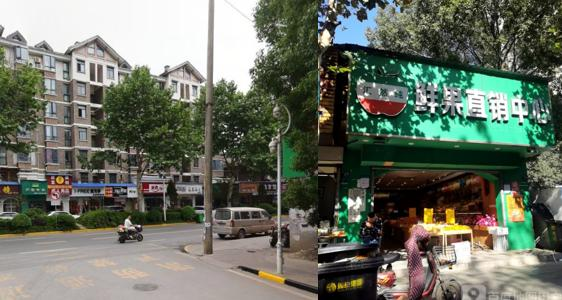

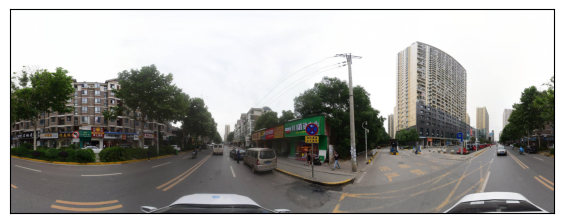

In [53]:
%%time
question = "我现在在什么地方？以及周边有什么东西？"
query_imgs = [
    'E:/RAG_LLM/test17.png',
    'E:/RAG_LLM/test18.png',
    # 'E:/RAG_LLM/test3.png',
]

multi_img = multi_img_retrieve(query_imgs)
####
leaf_results = []
for query_img in query_imgs:
    leaf_results.extend(leaf_retriever(leaf_indexing, query_img, topk=5))
####
parent_response, average_score = parent_retriever(parent_indexing, Rerank(
    orig_img=multi_img,
    parent_img='E:/RAG_LLM/wuhan/wuhan_test_img',
    merge_image=AutoMerge(leaf_results),
    topk=1
))
####
image, text, metadata = parent_retrieved_vis(parent_response, average_score)

####
# image_documents = [ImageDocument(image_path=multi_img)]
# for res_img in image:
#     image_documents.append(ImageDocument(image_path=res_img))
context_str = "".join(text)
metadata_str = metadata
####
print(get_answer_to_question(question, context_str, metadata_str))

Image.open(multi_img)

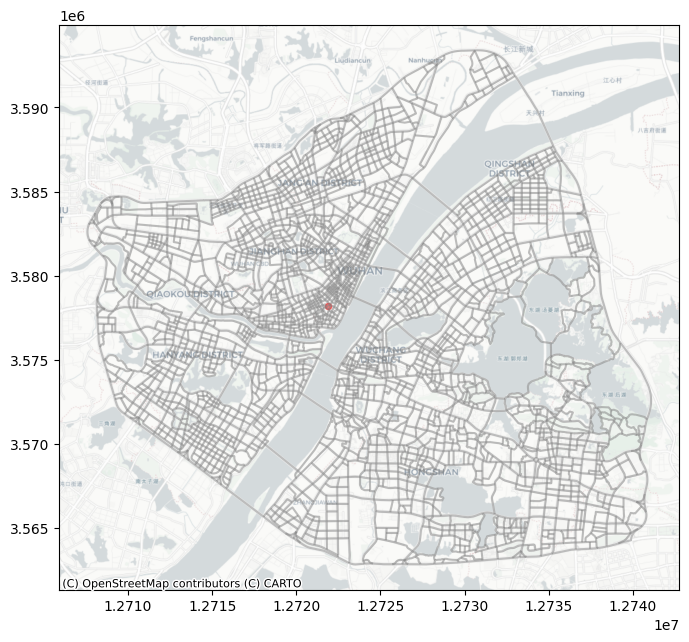

In [7]:
plot_location(metadata_str)

In [38]:
from llama_index.llms.ollama import Ollama
mm_model = Ollama(model="llava")
# resp = mm_model.complete("Who is Paul Graham?")
from llama_index.core import PromptTemplate

qa_tmpl_str = (
    "Given the provided information, including retrieved contents and metadata, \
     accurately and precisely answer the query without any additional prior knowledge.\n"
     "请使用中文回答。\n"
    # "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"     ## 将上下文信息放进去
    "Metadata: {metadata_str} \n"  ## 将原始的meta信息放进去
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)
query_str = '告诉我现在在什么位置？描述一下周边场景长啥样。'
prompt = qa_tmpl_str.format(
        context_str=context_str,
        metadata_str=metadata_str,
        query_str=query_str
        )
## use'.complete' invoke LLM
response = mm_model.stream_complete(prompt)
# response.text
for r in response:
    print(r.delta, end="")

 您当前位于湖北省武汉市江汉区中山大道451号，周围有许多商店和停车场，如名发世家、非凡摄影、系恋等。周边的长度是一条路线，包括两个交通设施服务的停车场，一个生活服务的购物区域，以及几个个人用品店和服装鞋帽皮具店。在这个地点周围，您可以找到许多商业建筑和商店，提供各种购物和服务选项，同时周边还有大量的树木和绿色环境，增强了该区域的美观度量。 

In [ ]:
# ' 您当前所处的位置是湖北省武汉市江汉区中山大道451号，周围场景是一个宽敞的街道，两侧都有建筑和树木，形成一片绿色。在左边的垂直图片中，可以看到街道上的高层建筑和植物，表现出城市的繁华与自然的共同。右边的横跨整个街道的图片则展示了一个普通的居民区域，两侧都有一些家庭住房和其他服务设施。在周围的商业区域，可以看到各种购物、美食和娱乐场所，如停车场、摄影店、服装鞋帽皮具店等。 '

In [61]:
from llama_index.core.prompts import PromptTemplate
qa_img_str = (
    "Given the images provided, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_text_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"               ##这里所指的context是指自动retrieve后的context内容
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

qa_img_tmpl = PromptTemplate(qa_img_str)
qa_text_tmpl = PromptTemplate(qa_text_str)

## query的方式查询
query_engine = parent_indexing.as_query_engine(
    llm=mm_model, 
    text_qa_template=qa_text_tmpl,
    image_qa_template=qa_img_tmpl,
    similarity_top_k=3, image_similarity_top_k=3
)

In [62]:
query_str ='I want to go a university with tress and sky'
# response = query_engine.query(query_str)
response = query_engine.image_query(query_img, query_str)
response.response

In [ ]:
" The image you've provided appears to be a panoramic or composite of three different photos, likely meant to convey the idea that one is embarking on an educational journey like the path between the buildings shown in these images. The first photo shows what seems to be a road with trees and sky above, which could symbolize a university campus being part of the larger environment. The second image captures a moment where two individuals appear to be crossing the street or moving towards the university building, signifying movement toward one's academic goals. The third image shows a more urban setting, possibly the university itself, with cars parked along the road and buildings in the background, which could symbolize the cityscape that is part of a student's life during their education journey. These photos together suggest the idea of moving from a place of learning to a place where one can apply that knowledge, and the transition between different stages or environments within an academic career. "


**Node ID:** a7d452e2-c027-4e00-98a3-146478412858<br>**Similarity:** 0.8889666277501768<br>**Text:** The image is a collage of three distinct photos capturing different views of an urban landscape.

In the leftmost photo, we see a bird's-eye view of a city street. Dominating the scene are towering...<br>**Image:**

**Node ID:** 2f8b7ebc-519f-4530-ab49-0e7a51c988c2<br>**Similarity:** 0.8884129015472986<br>**Text:** The image is a collage of two photographs showing the same urban street scene from different angles. Both photos depict a city street with buildings, trees, and various elements typically found in ...<br>**Image:**

**Node ID:** 4903839d-afb8-46fa-a9c2-8199820a6f20<br>**Similarity:** 0.8871499278506547<br>**Text:** The image is a composite of four photographs, arranged in a two-by-two grid. Each photo captures the same urban scene from different angles and weather conditions.

In the top left photo, it appear...<br>**Image:**

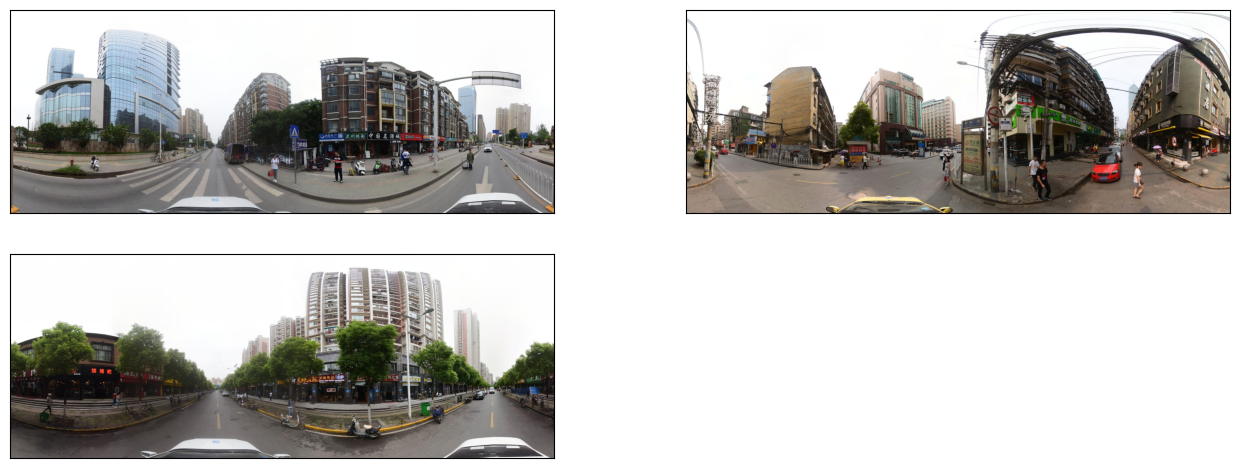

In [23]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.source_nodes[:3]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.node.image_path for n in response.metadata["image_nodes"][:3]]
)

In [52]:
##使用prompt，融入检索信息进行生成回答
mm_model = OllamaMultiModal(model="llava")
## LLM templet
qa_tmpl_str = (
    "Given the provided information, including retrieved contents and metadata, \
     accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"     ## 将上下文信息放进去
    "Metadata: {metadata_str} \n"  ## 将原始的meta信息放进去
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)
query_str = 'tell me the POI information based on metadata'

## use'.complete' invoke LLM
response = mm_model.complete(
    prompt=qa_tmpl_str.format(
        context_str=context_str,
        metadata_str=metadata_str,
        query_str=query_str, 
        ),
    image_documents=image_documents,
    )

In [ ]:
response.text

' The relationship between these images is that they are a collage showing different perspectives of the same urban scene. Each photo captures a unique aspect of the street and its surroundings, providing a comprehensive view of what might be happening in this location at a given time. By presenting multiple angles in one image, it allows viewers to compare and contrast the details of the environment they might not see from a single perspective. '

' The relationship between these images is that they are a collage showing different perspectives of the same urban scene. Each photo captures a unique aspect of the street and its surroundings, providing a comprehensive view of what might be happening in this location at a given time. By presenting multiple angles in one image, it allows viewers to compare and contrast the details of the environment they might not see from a single perspective. '

**Node ID:** 4fd82867-f39b-4bcb-bf32-d47368b9c515<br>**Similarity:** 0.7689810629559196<br>**Text:** <br>**Image:**

**Node ID:** 6c16dced-b839-4f04-b329-43f39d83877c<br>**Similarity:** 0.7538432772835675<br>**Text:** <br>**Image:**

**Node ID:** 9e3a327c-1baf-454e-8acb-0970717fae07<br>**Similarity:** 0.7532479175591551<br>**Text:** <br>**Image:**

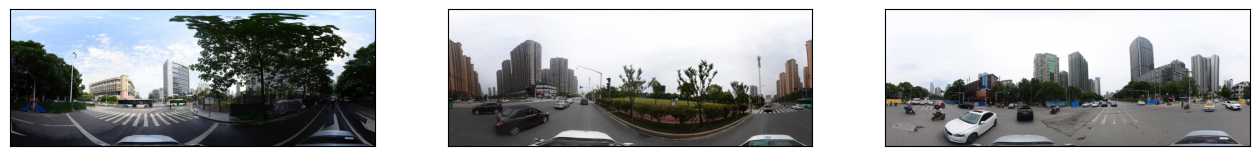

In [65]:
# Define a function to plot images given a list of image paths
def plot_image(image_paths):
    # Initialize a counter to track the number of images shown
    images_shown = 0
    # Set the figure size for the entire plot
    plt.figure(figsize=(16, 9))
    # Iterate through each image path in the provided list
    for img_path in image_paths:
        # Check if the file exists
        if os.path.isfile(img_path):
            # Open the image using the Image module
            image = Image.open(img_path)
            # Create a subplot for the current image in a 2x3 grid
            plt.subplot(2, 3, images_shown + 1)
            # Display the image in the subplot
            plt.imshow(image)
            # Remove x and y ticks for clarity
            plt.xticks([])
            plt.yticks([])
            # Increment the counter for images shown
            images_shown += 1
            # Break the loop if 9 images have been shown
            if images_shown >= 9:
                break

## define retrive function
def retrieve_display(retrieval_results):
    retrieved_image = []
    retrieved_image_score = []
    retrieved_text = []
    retrieved_metadata = []
    for res_node in retrieval_results[0:3]:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.image_path)
            retrieved_image_score.append(res_node.score)
            retrieved_text.append(res_node.text)
            retrieved_metadata.append(res_node.metadata)
            display_source_node(res_node, source_length=200)
        else:
            display_source_node(res_node, source_length=200)
            # retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text, retrieved_image_score, retrieved_metadata

test = parent_indexing.as_retriever(similarity_top_k=3, image_similarity_top_k=3)
img, txt, score, metadata = retrieve_display(test.image_to_image_retrieve(query_img))

plot_image(img)

In [48]:
metadata

[{'file_path': 'e:\\RAG_LLM\\wuhan_test_img\\124_09000200121905241441020118V.jpg',
  'file_name': '124_09000200121905241441020118V.jpg',
  'file_type': 'image/jpeg',
  'file_size': 1141832,
  'creation_date': '2024-04-02',
  'last_modified_date': '2024-03-31'},
 {'file_path': 'e:\\RAG_LLM\\wuhan_test_img\\101_09000200121905121424028412P.jpg',
  'file_name': '101_09000200121905121424028412P.jpg',
  'file_type': 'image/jpeg',
  'file_size': 970202,
  'creation_date': '2024-04-02',
  'last_modified_date': '2024-03-31'},
 {'file_path': 'e:\\RAG_LLM\\wuhan_test_img\\102_09000200121905121424245032P.jpg',
  'file_name': '102_09000200121905121424245032P.jpg',
  'file_type': 'image/jpeg',
  'file_size': 635636,
  'creation_date': '2024-04-02',
  'last_modified_date': '2024-03-31'}]

In [91]:
import geopandas as gpd
import contextily as cx

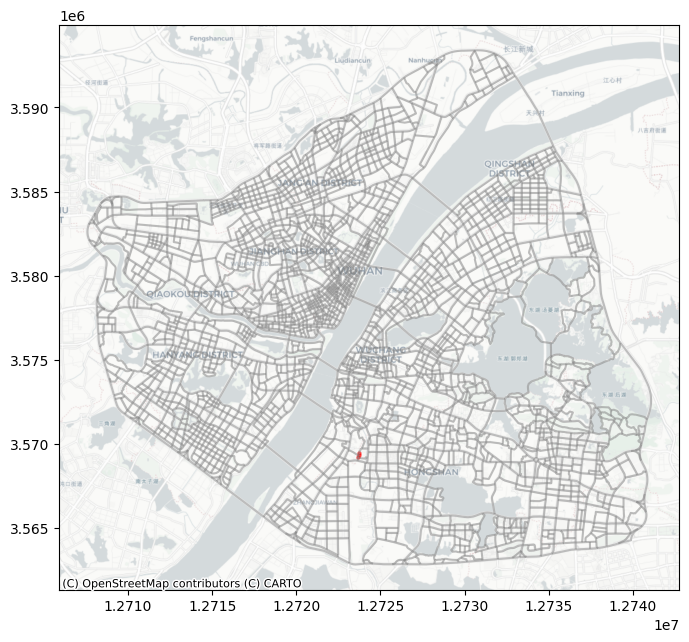

In [112]:
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
# 输入坐标点
coordinates = [[114.2991019, 30.5114472],
               [114.2989824, 30.5105618],
               [114.2986763, 30.50969999]]

# 创建坐标点的 GeoDataFrame
geometry = [Point(coord) for coord in coordinates]
# df_loc = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

gdf = gpd.GeoDataFrame(geometry=geometry, columns=['geometry'], crs='EPSG:4326')
df_loc = gdf.to_crs('EPSG:3857')

boundry = gpd.read_file("E:/RAG_LLM/wuhan_roadnetworks/单线WGS.shp")
boundry.crs = 'EPSG:4326'
line = boundry.to_crs('EPSG:3857')

line.plot(ax=ax, alpha=0.5, color='gray')
df_loc.plot(ax=ax, alpha=0.5, color="r", markersize=5)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
# ax.set_axis_off()

In [126]:
from llama_index.core.node_parser import get_leaf_nodes, get_root_nodes
leaf_nodes = get_leaf_nodes(image_nodesss)
leaf_nodes

[ImageNode(id_='001', embedding=None, metadata={'Boring': 0.223}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='这里是杭州的一条小路', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='20.695691_-103.362361_51413371fdc9f049260042da_Guadalajara.JPG', image_url=None, image_mimetype=None, text_embedding=None),
 ImageNode(id_='002', embedding=None, metadata={'Boring': 0.999}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='这里是新加坡的一条街道', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='20.698723_-103.385711_51413409fdc9f049260044f1_Guadalajara.JPG', image_url=None, image_mimetype=None, text_embedding=None)]

In [127]:
all = MultiModalVectorStoreIndex(image_nodesss)
base = MultiModalVectorStoreIndex(leaf_nodes)

In [135]:
from llama_index.core.retrievers import AutoMergingRetriever
basic = base.as_retriever(image_similarity_top_k=5)
resp = basic.image_to_image_retrieve(img_path)

# retriever = AutoMergingRetriever(basic, all, verbose=True)

resp.

In [136]:
resp

[NodeWithScore(node=ImageNode(id_='001', embedding=None, metadata={'Boring': 0.223}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='这里是杭州的一条小路', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='20.695691_-103.362361_51413371fdc9f049260042da_Guadalajara.JPG', image_url=None, image_mimetype=None, text_embedding=None), score=0.5996515642932855),
 NodeWithScore(node=ImageNode(id_='002', embedding=None, metadata={'Boring': 0.999}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='这里是新加坡的一条街道', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='20.698723_-103.385711_51413409fdc9f049260044f1_Guadalajara.JPG', image_url=None, image_mimetype=None, text_embedding=None), score=0.4840

In [ ]:
from llama_index.core.node_parser import HierarchicalNodeParser
from llama_index.core.node_parser import get_leaf_nodes

# 结构化node划分，2048-->512-->128
node_parser = HierarchicalNodeParser.from_defaults(
    chunk_sizes=[512, 128, 64]
)
nodes = node_parser.get_nodes_from_documents(
    [Document(text=text,
          metadata={
              "filename":"bbb",
              "categery":"kkk"
          })], show_progress=False
)
print(len(nodes))

##把叶子节点提取出来
leaf_nodes = get_leaf_nodes(nodes)
print(len(leaf_nodes))

In [26]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter

documents = SimpleDirectoryReader("E:/RAG_LLM/test/").load_data()
node_parser = SentenceSplitter.from_defaults()
leaf_nodes = node_parser.get_nodes_from_documents(documents)

# index = MultiModalVectorStoreIndex.from_documents(
#     documents=documents,
#     # storage_context=storage_context,
#     show_progress=True
# )

In [29]:
leaf_nodes[0].relationships

{<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='2e2751b0-0c6f-4549-8d7f-fda870cd87ba', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'E:\\RAG_LLM\\test\\11_09000200011704231032257502R_patch_0_0.jpg', 'file_name': '11_09000200011704231032257502R_patch_0_0.jpg', 'file_type': 'image/jpeg', 'file_size': 81696, 'creation_date': '2024-04-02', 'last_modified_date': '2024-04-02'}, hash='9a8e1fe51d842a9b2e15c31a0dccc8fb598ef7fe28108d9c8a149f7fe611b23c'),
 <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='c451784e-d2c0-4591-a8c7-1f27b9f21905', node_type=<ObjectType.IMAGE: '2'>, metadata={}, hash='44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a')}

In [23]:
##使用.as_retriever创建一个检索器
urban_retrieve = index.as_retriever(similarity_top_k=10, image_similarity_top_k=10)

In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.storage.docstore import SimpleDocumentStore
from llama_index.core.retrievers import AutoMergingRetriever
##创建docstore储存node里面的doc
##参考https://docs.llamaindex.ai/en/stable/examples/docstore/DocstoreDemo/?h=simpledocumentstore
##参考https://blog.csdn.net/weixin_42608414/article/details/135666037
docstore = SimpleDocumentStore()
docstore.add_documents(nodes)

##创建容器把docstore放进去
storage_context = StorageContext.from_defaults(docstore=docstore)

#创建向量库索引index的数量等于叶子节点的数量
automerging_index = VectorStoreIndex(
    leaf_nodes,
    storage_context=storage_context)
##创建一个基于叶子节点的基础检索器
base_retriever = automerging_index.as_retriever(similarity_top_k=5)
##merge检索器在检索时只拿叶子节点和问题进行匹配，
##当某个父节点下的多数叶子节点都与问题匹配上则将该父节点作为context返回给LLM
retriever = AutoMergingRetriever(base_retriever, storage_context, verbose=True)

**Node ID:** aafecca9-0413-45db-9f44-7bd754cb31a1<br>**Similarity:** 0.7677246420917129<br>**Text:** <br>**Image:**

**Node ID:** d5f00ba0-737b-4844-8428-beef575066e2<br>**Similarity:** 0.7614236443957377<br>**Text:** <br>**Image:**

**Node ID:** d65f3e00-b49f-4acf-861a-f03bcf6d2098<br>**Similarity:** 0.7523525922548923<br>**Text:** <br>**Image:**

**Node ID:** a4df5543-68ee-4d68-8ae7-03187d0771c2<br>**Similarity:** 0.7437759981469682<br>**Text:** <br>**Image:**

**Node ID:** 8d5d2166-1bde-460a-a91f-9cb2e1d0fb49<br>**Similarity:** 0.7387070206351721<br>**Text:** <br>**Image:**

**Node ID:** 3ed73a27-435d-4e47-8752-dc0354c68a8a<br>**Similarity:** 0.727640101971869<br>**Text:** <br>**Image:**

**Node ID:** 37d8f4c5-dc0e-4f51-bc39-b7bd0bf26ae3<br>**Similarity:** 0.7218338384586993<br>**Text:** <br>**Image:**

**Node ID:** a4126970-a3ca-4663-8b8d-f085a0646146<br>**Similarity:** 0.7207748195974288<br>**Text:** <br>**Image:**

**Node ID:** 084ffe46-cade-48ce-942c-43791a1f177e<br>**Similarity:** 0.7142739635146919<br>**Text:** <br>**Image:**

**Node ID:** c3e7d21b-f547-4b0a-840a-6110320fdafd<br>**Similarity:** 0.7001438361093044<br>**Text:** <br>**Image:**

[0.7677246420917129, 0.7614236443957377, 0.7523525922548923, 0.7437759981469682, 0.7387070206351721, 0.727640101971869, 0.7218338384586993, 0.7207748195974288, 0.7142739635146919, 0.7001438361093044]


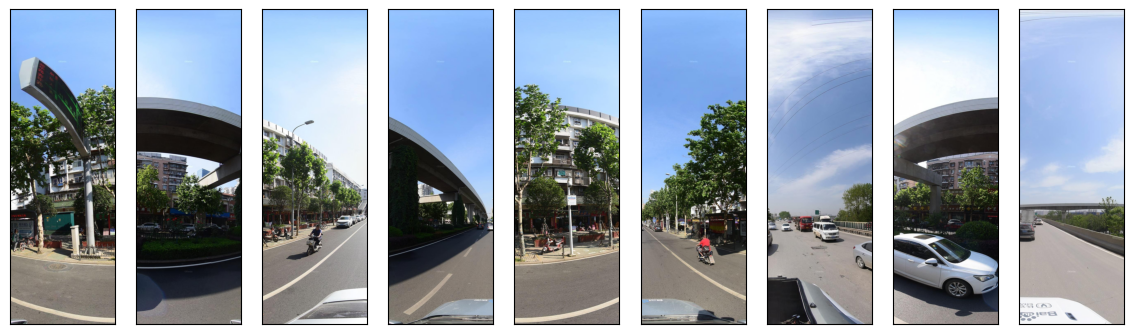

In [24]:
img_path = '37_09000200121905231554463318V.jpg'
# img, txt, score, metadata = retrieve_display(urban_retrieve.retrieve(img_path))  ##多模态检索
img, txt, score, metadata = retrieve_display(urban_retrieve.image_to_image_retrieve(img_path))  ##图像到图像检索

print(score)
plot_images(img[0:10])  ## visualization

In [6]:
import os
import csv
import shutil

source_folder = 'E:/BaiduNetdiskDownload/wuhan_svi'  # 替换为源文件夹的路径
target_folder = 'wuhan_test_img'  # 替换为目标文件夹的路径
csv_file = 'test_id.csv'  # 替换为包含图片 ID 和 panoid 的 CSV 文件的路径

# 读取 CSV 文件
with open(csv_file, 'r', encoding='gbk') as file:
    reader = csv.DictReader(file)
    for row in reader:
        panoid = row['panoid']
        image_file = f"{row['id']}_{panoid}.jpg"  # 构建图片文件名

        # 构建源文件和目标文件的完整路径
        source_path = os.path.join(source_folder, image_file)
        target_path = os.path.join(target_folder, image_file)

        # 检查源文件是否存在
        if not os.path.exists(source_path):
            print(f"源文件不存在：{source_path}")
            continue

        # 复制文件
        shutil.copyfile(source_path, target_path)

源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\913_09000200121905071015493509G.jpg
源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\920_02000200001406181236096803B.jpg
源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\964_09000200121905081304514579R.jpg
源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\965_09000200121905081305137519R.jpg
源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\966_09000200121905081306009979R.jpg
源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\967_09000200121905081306139179R.jpg
源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\968_09000200121905081306251659R.jpg
源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\969_09000200121905140940511092P.jpg
源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\970_09000200121905140940568902P.jpg
源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\971_09000200121905140941025782P.jpg
源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\972_09000200121905140941083442P.jpg
源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\973_09000200121905140931049882P.jpg
源文件不存在：E:/BaiduNetdiskDownload/wuhan_svi\974_09000200121905140941183712P.jpg

In [9]:
# import os
# import csv

# # 读取目标文件夹下所有文件的文件名
# folder_path = 'E:/RAG_LLM/wuhan/wuhan_test_img'
# file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# # 写入CSV文件
# with open('file_names.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     for name in file_names:
#         writer.writerow([name])


import os
import csv

folder_path = 'E:/RAG_LLM/wuhan/wuhan_test_img'  # 替换为目标文件夹的路径
csv_file = 'file_names.csv'  # 替换为输出 CSV 文件的路径

# 获取文件夹中的图像文件列表
image_files = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

# 写入 CSV 文件
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path_and_name'])  # 写入表头

    for image_file in image_files:
        image_path_and_name = os.path.join(folder_path, image_file)
        writer.writerow([image_path_and_name])